In [1]:
from time import time
from collections import Counter
import pprint

import re
import stop_words
import string

import sqlite3
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

# nltk
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups

# gensim
import gensim
from gensim import corpora
from gensim import models
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import STOPWORDS

C:\Users\takis\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


* Get filtered data
* Select table ...

In [2]:
path_to_db = r"C:\Users\takis\Desktop\PyR\projects\WebScraping\bookmarks.sqlite"

In [3]:
dtb = sqlite3.connect(path_to_db)

In [13]:
query_string =  '''
                SELECT * FROM articles
                '''

In [14]:
df = pd.read_sql(query_string,dtb)

In [15]:
df.shape

(3220, 1)

* Custom preprocessing

In [16]:
# HELPERS
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])
stopwords = set(STOPWORDS)
lemmatizer = WordNetLemmatizer()

# PREPROCESSING
body0 = df.body.str.lower().str.replace(RE_PUNCTUATION, ' ').str.strip().str.split()
body1 = body0.apply(lambda tokens: [token for token in tokens if token not in stopwords])
body2 = body1.apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# corpus for analysis
corpus = [" ".join(x) for x in body2]

In [175]:
def prep_corpus(series):
    # helper
    RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])
    stopwords = set(STOPWORDS)
    lemmatizer = WordNetLemmatizer()

    # PREPROCESSING
    body0 = series.str.lower().str.replace(RE_PUNCTUATION, ' ').str.strip().str.split()
    body1 = body0.apply(lambda tokens: [token for token in tokens if token not in stopwords])
    body2 = body1.apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

    # corpus for analysis
    corpus = [" ".join(x) for x in body2]
    return corpus

In [176]:
corpus = prep_corpus(df.body)

* __CountVectorizer__

In [178]:
cvect = CountVectorizer(stop_words ="english",
                        lowercase = True,
                        strip_accents = 'unicode',
                        token_pattern=r'\b[a-zA-Z]{3,}\b', 
                        min_df=0.013, max_df = 0.13)

cvect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.13, max_features=None, min_df=0.013,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='\\b[a-zA-Z]{3,}\\b',
        tokenizer=None, vocabulary=None)

In [179]:
X = cvect.fit_transform(corpus)

In [180]:
X.toarray().shape
# documents X tokens

(3220, 3177)

* __TD_IDF__ transformer

In [ ]:
tfidf_trans = TfidfTransformer()
X_tf = tfidf_trans.fit_transform(X)
X_tf.shape

In [ ]:
X_tf.toarray()

* __LDA__

In [168]:
n_topics = 12

In [181]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=300,
                                learning_method='online',
                                random_state=0,
                                n_jobs=-1)

In [182]:
t0 = time()
lda.fit(X)
print("done in %0.3fs." % (time() - t0))

C:\Users\takis\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 614.637s.


In [150]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        topic_sum = topic.sum()
        print("Topic #%d:" % topic_idx)
        print(" + ".join(["%0.3f*'%s'" % (topic[i] / topic_sum, feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [183]:
print("Topics in LDA model:")
tf_feature_names = cvect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=5)

Topics in LDA model:
Topic #0:
0.028*'dataframe' + 0.023*'row' + 0.022*'panda' + 0.014*'plot' + 0.014*'select'
Topic #1:
0.038*'conference' + 0.023*'policy' + 0.022*'game' + 0.017*'reinforcement' + 0.016*'agent'
Topic #2:
0.060*'tree' + 0.035*'validation' + 0.030*'forest' + 0.024*'xgboost' + 0.023*'boosting'
Topic #3:
0.009*'observation' + 0.009*'outlier' + 0.009*'variance' + 0.008*'correlation' + 0.008*'cluster'
Topic #4:
0.021*'device' + 0.020*'iot' + 0.017*'car' + 0.012*'internet' + 0.011*'app'
Topic #5:
0.006*'career' + 0.006*'report' + 0.006*'risk' + 0.005*'financial' + 0.004*'manager'
Topic #6:
0.004*'game' + 0.004*'brain' + 0.003*'experiment' + 0.003*'wrong' + 0.003*'theory'
Topic #7:
0.026*'weight' + 0.024*'matrix' + 0.022*'gradient' + 0.017*'neuron' + 0.017*'vector'
Topic #8:
0.018*'convolutional' + 0.018*'pixel' + 0.017*'map' + 0.017*'filter' + 0.016*'cnn'
Topic #9:
0.034*'spark' + 0.028*'hadoop' + 0.020*'pipeline' + 0.020*'sql' + 0.016*'api'
Topic #10:
0.030*'kunal' + 0.019*

In [184]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda,X,cvect)

C:\Users\takis\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.053618  0.098201       1        1  17.447484
5     -0.155044  0.044753       2        1  17.278013
3      0.159875  0.102053       3        1  12.849278
7      0.162063  0.088587       4        1   7.869827
0      0.172290 -0.044238       5        1   7.397648
9     -0.056052  0.041616       6        1   6.539133
4     -0.178451  0.145618       7        1   6.407898
10    -0.043712 -0.164653       8        1   6.181790
11    -0.014275 -0.051310       9        1   5.851275
8      0.048375  0.135934      10        1   4.396690
2      0.220814 -0.209154      11        1   4.042001
1     -0.262265 -0.187407      12        1   3.738964, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
2971  Default  1782.000000           tree  1782.000000  30.0000  30.0000
2706  Default  1556.000000          spark  1556.000000  29.0000  29.0000
714   Default  1431.000000      dataframe  1431.000000  28.0000  28.0000
1635  Default  1313.000000          kunal  1313.000000  27.0000  27.0000
1324  Default  1282.000000         hadoop  1282.000000  26.0000  26.0000
3119  Default  1800.000000         weight  1800.000000  25.0000  25.0000
3049  Default  1116.000000     validation  1116.000000  24.0000  24.0000
2896  Default  1467.000000     tensorflow  1467.000000  23.0000  23.0000
558   Default   988.000000     conference   988.000000  22.0000  22.0000
1284  Default  1453.000000       gradient  1453.000000  21.0000  21.0000
1793  Default  1749.000000         matrix  1749.000000  20.0000  20.0000
2066  Default  1220.000000          panda  1220.000000  19.0000  19.0000
2516  Default  1446.000000            row  1446.000000  18.0000  18.0000
1195  Default   895.000000         forest   895.000000  17.0000  17.0000
1241  Default  1142.000000           game  1142.000000  16.0000  16.0000
810   Default   934.000000         device   934.000000  15.0000  15.0000
1584  Default   897.000000            iot   897.000000  14.0000  14.0000
2155  Default  1440.000000           plot  1440.000000  13.0000  13.0000
2524  Default  1018.000000           sale  1018.000000  12.0000  12.0000
2138  Default  1105.000000       pipeline  1105.000000  11.0000  11.0000
1930  Default   973.000000         neuron   973.000000  10.0000  10.0000
2738  Default  1055.000000            sql  1055.000000   9.0000   9.0000
3062  Default  1653.000000         vector  1653.000000   8.0000   8.0000
687   Default   911.000000          cross   911.000000   7.0000   7.0000
3166  Default   675.000000        xgboost   675.000000   6.0000   6.0000
312   Default   640.000000       boosting   640.000000   5.0000   5.0000
1590  Default  1016.000000           item  1016.000000   4.0000   4.0000
1637  Default  1224.000000          label  1224.000000   3.0000   3.0000
480   Default  1182.000000        cluster  1182.000000   2.0000   2.0000
2164  Default   656.000000         policy   656.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2391  Topic12    64.778656   registration    75.527737   3.1328  -5.9973
413   Topic12   128.617747          chair   150.094222   3.1319  -5.3114
1963  Topic12    83.011375            nov    98.268009   3.1176  -5.7493
100   Topic12   152.066173        alphago   181.293917   3.1106  -5.1440
2396  Topic12   448.150842  reinforcement   538.435385   3.1028  -4.0632
1597  Topic12   121.994380            jan   146.805388   3.1012  -5.3643
1579  Topic12    53.170424         invite    64.167830   3.0984  -6.1948
1720  Topic12    52.290993           logo    64.730308   3.0730  -6.2115
1213  Topic12   138.392797      francisco   175.097877   3.0511  -5.2382
72    Topic12   424.921043          agent   579.904337   2.9754  -4.1164
866   Topic12   176.076037           door   231.167123   3.014

In [207]:
topic_list = ['general',
              'fs',
              'stat',
              'ml',
              'python',
              'distributed computing',
              'iot',
              'vidhya',
              'nlp',
              'cnn',
              'tree boosters',
              'reinf learning']

* Model Persistence

In [186]:
from sklearn.externals import joblib
# from joblib import dump, load
joblib.dump(lda,"lda_model.pkl")

['lda_model.pkl']

### get topic for new article

* first profile the topics

In [202]:
new_text = corpus[53]
new_text[:500]

'building scikit learn pipeline panda dataframes april 16 2018 i’ve scikit learn number year useful tool building machine learning pipeline difficult frustrating integrate scikit learn panda dataframes especially production code scikit learn course dataframe numpy array extra sugar data manipulation sugar help identify column type keep track feature name calculating feature importance what’s worse categorical feature consistently pita encoded require separate processing rule imputing frequent val'

In [193]:
def extract_topic(article,model,topic_list):
    top_distr = lda.transform(cvect.transform([article]))
    res = DataFrame(top_distr,columns=topic_list)
    return res

In [204]:
xx = extract_topic(new_text,lda,topic_list)

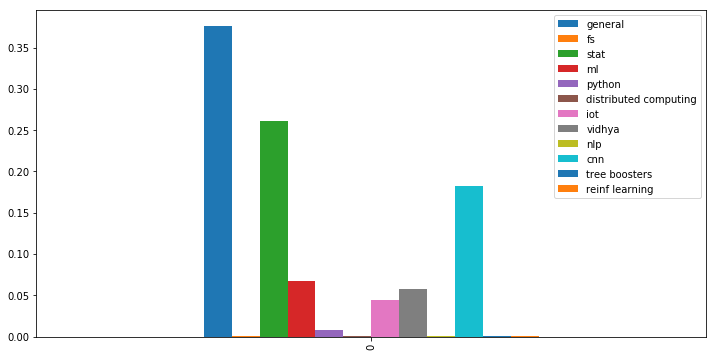

In [205]:
xx.plot(kind="bar",figsize=(12,6))

### Notebook

* Add new features in the dataset

In [ ]:
def get_domain(x):
    return x.split("//")[1].split("/")[0].replace(".com","").replace("www","").replace('.','').strip()

df['domain'] = df.link.apply(lambda x : get_domain(x))

In [ ]:
def get_dom_frq(x,counter_obj):
    return counter_obj[x]

urls = list(df.link)
domains = [x.split("//")[1].split("/")[0].replace(".com","").replace("www","").replace('.','').strip() for x in urls]
counter_obj = Counter(domains)

df['domain_frequency'] = df.domain.apply(lambda x : get_dom_frq(x,counter_obj))

* __Preprocessing__
* CountVectorizer

In [ ]:
# count vectorizer straight on the body text
# in general ok but no lemmatization and limited customization

# corpus = df.body[:10]
# cvect = CountVectorizer(stop_words ="english",
#                         lowercase = True,
#                         strip_accents = 'unicode',
#                         token_pattern=r'\b[a-zA-Z]{3,}\b', 
#                         min_df=1)
# X = cvect.fit_transform(corpus)
# X.toarray()
# cvect.get_feature_names()